In [2]:
import math
import torch
import torch.nn as nn

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

def get_generators(k: int, l: int, m: int, D: int=50) -> list[torch.nn.Module]:
    return [build_generator(l, m, D) for _ in range(k)]


@torch.no_grad()
def get_regression_targets(n:int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random', correlation: float=0, delta: float=0) -> tuple[torch.Tensor, torch.Tensor]:
    if sample_mode == 'random':
        z = torch.rand(n, k, l)
    elif sample_mode == 'diagonal':
        _n = 10*n
        z = torch.Tensor(0, k, l)
        while z.shape[0] < n:
            # sample randomly on diagonal
            _z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
            # apply random offset
            _z += torch.rand(n, k, l) * 2 * delta - delta
            # reject samples outside the domain
            mask = ~((_z - 0.5).abs() > 0.5).flatten(1).any(1)
            idx = mask.nonzero().squeeze()
            z = torch.cat([z, _z[idx]])
        z = z[:n]
    elif sample_mode == 'off_diagonal':
        _n = 10*n
        z = torch.Tensor(0, k, l)
        while z.shape[0] < n:
            # sample randomly in whole space
            _z = torch.rand(_n, k, l)  
            # compute distances between blocks
            triuidx = torch.triu_indices(k, k)  
            mutual_distances = (_z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1) - _z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :]
            # reject samples on diagonal
            mask = (mutual_distances.abs() > 2*delta).any(dim=1).all(dim=1)
            idx = mask.nonzero().squeeze()
            z = torch.cat([z, _z[idx]])
        z = z[:n]
    elif sample_mode == 'orthogonal':
        _z = torch.rand(n, l)
        mask = torch.stack([torch.arange(n), torch.randint(k, (n, 1)).squeeze(dim=1)], dim=1).long()
        z = torch.zeros(n, k, l)
        z[mask.chunk(chunks=2, dim=1)] = _z.unsqueeze(1)
    elif sample_mode == 'mix':
        n_diag = int(n * correlation,)
        _z_diag = torch.repeat_interleave(torch.rand(n_diag, l), k, dim=0).reshape(n_diag, k, l)
        _z_rand = torch.rand(n - n_diag, k, l)
        z = torch.cat([_z_diag, _z_rand])[torch.randperm(n)]
    
    x = [torch.stack([generators[j](z[i][j]) for j in range(k)]) for i in range(n)]
    x = torch.stack(x)

    return z, x

def build_generator(l: int, m: int, D: int, slope: float=0.2) -> nn.Sequential:
    g = nn.Sequential(
        nn.Linear(l, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, m),
        nn.LeakyReLU(slope)
    )
    g.apply(init_min_cond)
    return g


def init_min_cond(m: torch.nn.Module, n_samples: int=7500) -> torch.Tensor:
    if isinstance(m, nn.Linear):
        w = m.weight.data
        k = 1 / w.size(0)

        w = torch.nn.functional.normalize(w, p=2)
        cond = condition_number(w)

        for _ in range(n_samples):
            _w = 2 * math.sqrt(k) * torch.rand(w.size()) - math.sqrt(k)
            _w = nn.functional.normalize(_w, p=2)
            _cond = condition_number(_w)

            if _cond < cond:
                w = _w
                cond = _cond
        
        m.weight.data = w


def condition_number(t: torch.Tensor) -> float:
    return torch.norm(t, p=2) / torch.norm(torch.pinverse(t), p=2)


In [3]:
def build_MLP(d_in: int, d_out: int, D: int=120, slope: float=0.2, **kwargs) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(d_in, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, d_out),
        nn.LeakyReLU(slope)
    )


def MLP(k: int, l: int, m: int, D: int=120, **kwargs):
    return build_MLP(k * m, k * l, D, **kwargs)


def MLPTanh(k: int, l: int, m: int, D: int=120, **kwargs):
    return nn.Sequential(
        nn.Linear(k * m, D),
        nn.Tanh(),
        nn.Linear(D, k * l),
        nn.Tanh()
    )


class CompositionalMLP(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(CompositionalMLP, self).__init__()
        self.k = k
        self.models = nn.ModuleList([build_MLP(k * m, l, round(D / k), **kwargs) for _ in range(k)])
    
    def forward(self, x):
        x = x.reshape(x.size(0), self.k, -1)
        out = []
        for i in range(len(self.models)):
            x_i = torch.zeros_like(x)
            x_i[:, i, :] = x[:, i, :]
            x_i = torch.flatten(x_i, start_dim = 1)
            out.append(self.models[i](x_i))
        return torch.cat(out, dim=1)


class Autoencoder(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(Autoencoder, self).__init__()
        self.f = build_MLP(k * m, k * l, D, **kwargs)
        self.g = build_MLP(k * l, k * m, D, **kwargs)
    
    def forward(self, x):
        z = self.f(x)
        out = self.g(z)
        return out, z

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import functorch
from torchmetrics import R2Score
from tqdm import tqdm


# could be more efficient with torch.utils.data.TensorDataset, but I couldn't be assed to look up the documentation
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], **sample_kwargs):
        super(Dataset, self).__init__()
        self.n = n
        self.z, self.x = get_regression_targets(n, k, l, generators, **sample_kwargs)
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx]


class OODDataset(Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], **sample_kwargs):
        super(Dataset, self).__init__()
        self.n = n
        if sample_kwargs['sample_mode'] == 'diagonal':
            sample_kwargs['sample_mode'] = 'off_diagonal'
        else:
            raise NotImplementedError
        self.z, self.x = get_regression_targets(n, k, l, generators, **sample_kwargs)


def train(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, epochs: int=10):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cum_loss = 0

        for batch, data in enumerate(trainloader, 0):
            x, z = data

            optimizer.zero_grad()

            out = model(torch.flatten(x, start_dim=1))
            loss = criterion(out, torch.flatten(z, start_dim=1))
            cum_loss += loss
            loss.backward()
            optimizer.step()
        
        cum_loss /= (batch + 1)
    
    return cum_loss


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, regularization: torch.nn.Module=None, lamda: float=0.5, **reg_kwargs):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)

        z_hat = model(x)
        loss = criterion(z_hat, z)
        if regularization is not None:
            loss += lamda * regularization(model, x, **reg_kwargs)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter_reg_ae(enc: torch.nn.Module, dec: torch.nn.Module, trainloader: torch.utils.data.DataLoader, regularization, lamda: float=0.5, lr: float=0.001):
    criterion = nn.MSELoss()
    reconstruction = nn.L1Loss()
    optimizer = optim.SGD({'encoder': enc.parameters(), 'decoder': dec.parameters()}, lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)

        z_hat = enc(x)
        x_hat = dec(z_hat)
        loss = criterion(z_hat, z) + reconstruction (x, x_hat) + lamda * regularization(dec, x)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


def comp_contrast(func: torch.nn.Module, inputs: torch.Tensor, **kwargs) -> torch.Tensor:
    """Calculate the compositional contrast for a function `func` with respect to `inputs`.

    The output is calculated as the mean over the batch dimension.
    `inputs` needs to be flattened except for the batch dimension and `requires_grad` needs to be set to `True`.
    """
    assert inputs.requires_grad == True, 'To calculate the derivative by `inputs` `requires_grad` needs to be set to `True`.'

    # compute the jacobian with respect to the inputs
    jac = functorch.vmap(functorch.jacrev(func))(inputs).transpose(1, 2)

    # compute the compositional contrast as the sum of all pairs of partial derivatives for all outputs
    # average over the batch dimension
    cc = torch.abs(jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)) * torch.abs(jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3))

    block_diagonal = torch.block_diag(*torch.ones(4, 2, 2, dtype=bool)).to(dev)

    cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((1, 2, 3)).mean()

    return cc


def sparse_hess(func: torch.nn.Module, inputs: torch.Tensor, p: int=0, **kwargs) -> torch.Tensor:
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.mean(hess.norm(dim=(1, 2, 3), p=p))


def sparse_hess2(func: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    # FIXME change sum() to norm
    mask = torch.ones(8, 40, 40, dtype=torch.uint8).to(dev)
    for i in range(4):
        mask[i*2:(i+1)*2, i*10:(i+1)*10, i*10:(i+1)*10] = 0
    
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.masked_select(hess, mask).sum()


@torch.no_grad()
def test(model: torch.nn.Module, testloader: torch.utils.data.DataLoader):
    cum_score = 0

    for batch, data in enumerate(testloader, 0):
        x, z = data
        out = model(torch.flatten(x.to(dev), start_dim=1))
        r2score = R2Score(out.size(1)).to(dev)
        score = r2score(out, torch.flatten(z.to(dev), start_dim=1))
        cum_score += score
    
    cum_score /= (batch + 1)
    return cum_score.to(torch.device('cpu')).item()

In [5]:
import copy

k = 4
l = 2
m = 10

torch.manual_seed(0)

print('Build generators...')
g = get_generators(k, l, m)

print('Build test data...')
te_ds = Dataset(1000, k, l, g, sample_mode='random')
te_ldr = torch.utils.data.DataLoader(te_ds, batch_size=1000, shuffle=True)

Build generators...
Build test data...


In [28]:
import os
import shutil
import datetime
import pandas as pd
import pickle as pk
from tqdm.notebook import tqdm

iter = 1000
bs = 4096
lr = 1
lr_steps = [5000]
experiment_suffix = ''

samplings = [
    {'str': 'rand', 'name': 'random', 'n': 4096, 'kwargs': {'sample_mode': 'random'}},
    {'str': 'orth', 'name': 'orthogonal', 'n': 4096, 'kwargs': {'sample_mode': 'orthogonal'}},
    {'str': 'diag', 'name': 'diagonal', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.}},
    {'str': 'diag001', 'name': 'diagonal ∆0.01', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.01}},
    {'str': 'diag002', 'name': 'diagonal ∆0.02', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.02}},
    {'str': 'diag005', 'name': 'diagonal ∆0.05', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.05}},
    {'str': 'diag01', 'name': 'diagonal ∆0.1', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.1}},
    {'str': 'diag02', 'name': 'diagonal ∆0.2', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.2}},
    {'str': 'diag05', 'name': 'diagonal ∆0.5', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.5}},
]

models = [
    # {'str': 'MLP', 'name': 'MLP', 'model': MLPTanh, 'regularizer': None, 'kwargs': {}},
    # {'str': 'MLPcomp', 'name': 'compositional MLP', 'model': CompositionalMLP, 'regularizer': None, 'kwargs': {}},
    {'str': 'MLPjac', 'name': 'MLP compositional contrast', 'model': MLPTanh, 'regularizer': comp_contrast, 'kwargs': {}},
    {'str': 'MLPhes0', 'name': 'MLP sparse hessian L0', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 0}},
    {'str': 'MLPhes1', 'name': 'MLP sparse hessian L1', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 1}},
    {'str': 'MLPhes2', 'name': 'MLP sparse hessian L2', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 2}},
]

res = []
now = datetime.datetime.now()
lr_str = str(lr).replace(".", "")
res_dir = f'res/{now:%Y%m%d%H%M}_i{iter}_lr{lr_str}_bs{bs}{experiment_suffix}'
if os.path.exists(res_dir): shutil.rmtree(res_dir)
os.mkdir(res_dir)

for sampling in tqdm(samplings, position=0):
    # print('Build train data...')
    n = sampling['n']
    n_batches = int(n / bs)
    tr_ds = Dataset(n, k, l, g, **sampling['kwargs'])
    tr_ldr = torch.utils.data.DataLoader(tr_ds, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds), bs, False))

    for model in tqdm(models, position=1, leave=False):
        # print('Build model...')
        mdl = model['model'](k, l, m).to(dev)

        # print('Train model...')
        for i in tqdm(range(iter), position=2, leave=False):
            if i in lr_steps: lr *= 0.1

            loss = train_iter(mdl, tr_ldr, lr=lr, regularizer=model['regularizer'], **model['kwargs'])
            r2 = test(mdl, te_ldr)

            res.append({'metric': 'train loss', 'n data': n, 'n samples': (i+1)*bs*n_batches, 'model': model['name'], 'sampling': sampling['name'], 'val': loss})
            res.append({'metric': 'test R²', 'n data': n, 'n samples': (i+1)*bs*n_batches, 'model': model['name'], 'sampling': sampling['name'], 'val': r2})
        
        # print('Save model...')
        torch.save(mdl.state_dict(), f"{res_dir}/{sampling['str']}_{model['str']}.pth")

print('Save results...')
res_df = pd.DataFrame.from_dict(res)
with open(f'{res_dir}/df.pkl', 'wb') as f:
    pk.dump(res_df, f)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Save results...


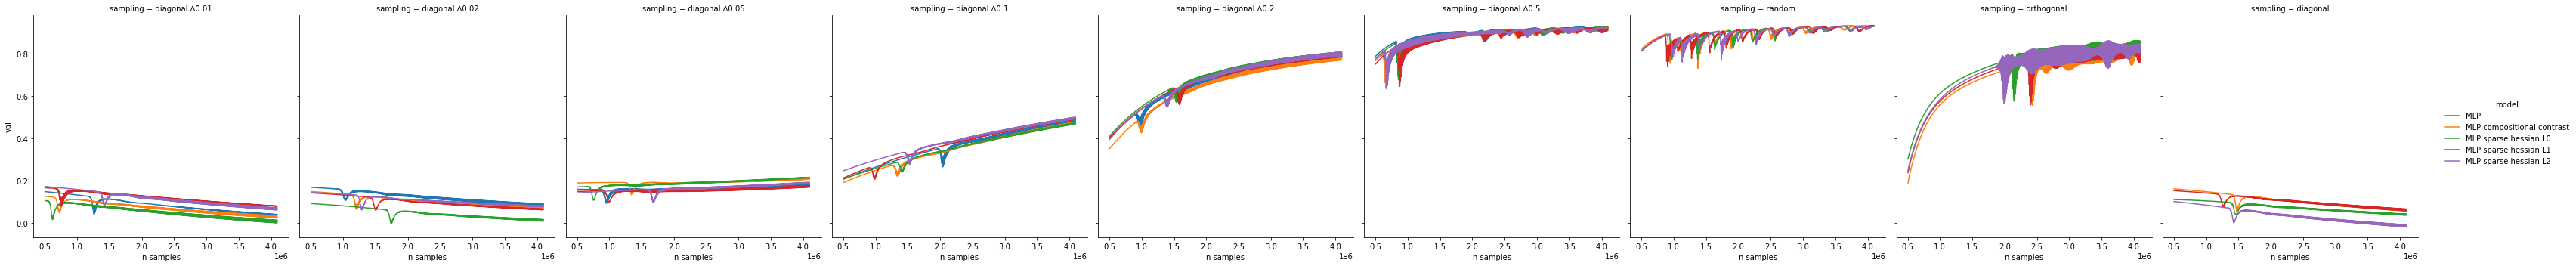

In [34]:
import pickle as pk
with open(r'res/202208031841_i1000_lr1_bs4096/df.pkl', 'rb') as f:
    res_normal = pk.load(f)
with open(r'res/202208031847_i1000_lr1_bs4096/df.pkl', 'rb') as f:
    res_reged = pk.load(f)
res_df = pd.concat([res_normal, res_reged])

import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n samples'] > 500000)], x='n samples', y='val', hue='model', col='sampling', kind='line')

In [ ]:
import os
import shutil
import datetime
import pandas as pd
import pickle as pk
from tqdm.notebook import tqdm

dirs = ['res/202208031847_i1000_lr1_bs4096', 'res/202208031841_i1000_lr1_bs4096']

samplings = [
    # {'str': 'orth', 'name': 'orthogonal', 'n': 4096, 'kwargs': {'sample_mode': 'orthogonal'}},
    {'str': 'diag', 'name': 'diagonal', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.}},
    {'str': 'diag001', 'name': 'diagonal ∆0.01', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.01}},
    {'str': 'diag002', 'name': 'diagonal ∆0.02', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.02}},
    {'str': 'diag005', 'name': 'diagonal ∆0.05', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.05}},
    {'str': 'diag01', 'name': 'diagonal ∆0.1', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.1}},
    {'str': 'diag02', 'name': 'diagonal ∆0.2', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.2}},
]

models = [
    {'str': 'MLP', 'name': 'MLP', 'model': MLPTanh, 'regularizer': None, 'kwargs': {}},
    {'str': 'MLPjac', 'name': 'MLP compositional contrast', 'model': MLPTanh, 'regularizer': comp_contrast, 'kwargs': {}},
    {'str': 'MLPhes0', 'name': 'MLP sparse hessian L0', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 0}},
    {'str': 'MLPhes1', 'name': 'MLP sparse hessian L1', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 1}},
    {'str': 'MLPhes2', 'name': 'MLP sparse hessian L2', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 2}},
]

def get_model_file(dirs, model_dict):
    for dir in dirs:
        model_file = f'{dir}/{sampling["str"]}_{model_dict["str"]}.pth'
        if os.path.exists(model_file):
            return model_file
    return None

res = []
for sampling in samplings:
    # construct ID and OOD sampler
    n = 1000
    id_ds = Dataset(n, k, l, g, **sampling['kwargs'])
    id_ldr = torch.utils.data.DataLoader(id_ds, batch_size=1000, shuffle=True)

    ood_ds = Dataset(n, k, l, g, **sampling['kwargs'])
    ood_ldr = torch.utils.data.DataLoader(id_ds, batch_size=1000, shuffle=True)
    

    for model in models:
        mdl = model['model'](k, l, m).to(dev)
        # try to load model
        model_file = get_model_file(dirs, model)
        assert model_file is not None
        mdl.load_state_dict(torch.load(model_file))

        # compute compositional contrast and Hessian sparsity on ID and OOD set

In [ ]:
with open(r'res/i500_lr0001_all.pkl', 'rb') as f:
    normal = pk.load(f)
    normal = normal.loc[normal['n samples'] == 4096]
with open(r'res/i500_lr0001_all_hess.pkl', 'rb') as f:
    hess = pk.load(f)
with open(r'res/i500_lr0001_all_jac2.pkl', 'rb') as f:
    jac = pk.load(f)
    jac['model'] = jac['model'].replace({'normal': 'comp contrast'})

res_df = pd.merge(jac, hess, 'outer')
res_df = pd.merge(res_df, normal, 'outer')

In [ ]:
import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n batches'] > 100000)], x='n batches', y='val', hue='model', col='sampling', kind='line')
[_fg.set_xlabel('n batches (size 4)') for _fg in fg.axes.ravel()]
[_fg.set_ylabel('R² score') for _fg in fg.axes.ravel()]